In [1]:
import os
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax
import itertools
import matplotlib.cm as cm
import numpy as np
import matplotlib
# Prevent ptitprince from raising cmap errors
cm.register_cmap = lambda name, cmap : matplotlib.colormaps.register(cmap, name=name)
import ptitprince as pt

import jax.numpy as jnp
import pypomp as pp
import ipywidgets as widgets
import pandas as pd
import copy

from jax import jit, grad
from functools import partial

from tqdm import tqdm


import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
np.set_printoptions(suppress=True)

In [50]:
runs = pd.read_csv('runs.csv', index_col=1).rename(columns={'Unnamed: 0': 'alpha'}).pivot(columns='alpha', values='logLik')
mifs = pd.read_csv('mif.csv', index_col=0)['logLik']
pres = pd.read_csv('pre.csv', index_col=0)['logLik']

In [29]:
quantiles = [0,0.5,0.8]
runs.quantile(quantiles).T.astype(float)

,0.0,0.5,0.8
alpha,,,
0.00,3752.213379,3791.536011,3818.041113
0.97,3748.533936,3768.072632,3785.934814
1.00,3751.766113,3783.761719,3800.509033


In [33]:
mifs

0     3842.101807
1     3830.384766
2     3876.963135
3     3881.307861
4     3906.281982
         ...     
95    4158.128418
96    3814.495117
97    3865.463379
98    3922.378418
99    3787.714111
Name: logLik, Length: 100, dtype: float64

In [49]:
runs[1.00].min()

3751.76611328125

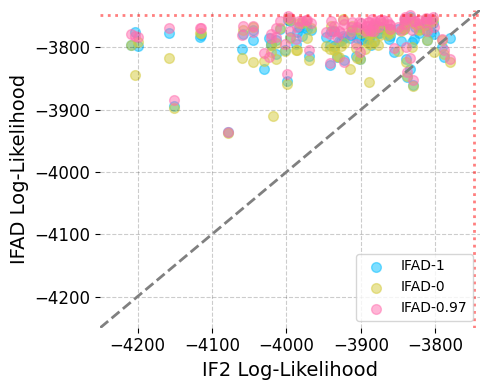

In [62]:
# IF2 0.95
plt.figure(figsize=(5,4))
# Overall paired searches, our IF2
plt.scatter(mifs, runs[1.0], marker='o', alpha=0.5,
            label='IFAD-1')
plt.scatter(mifs, runs[0.0], marker='o', alpha=0.5,
            label='IFAD-0')
plt.scatter(mifs, runs[0.97], marker='o', alpha=0.5,
            label='IFAD-0.97')
lo, hi = -4250, -3740
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5)

#plt.title('IFAD v.s. IF2, Paired Searches')

plt.xlabel('IF2 Log-Likelihood')
plt.ylabel('IFAD Log-Likelihood')
plt.legend()
plt.tight_layout()
# put horizontal and vertical lines at 3748.5
#plt.text(-3835, -3755, 'A', fontsize=36)

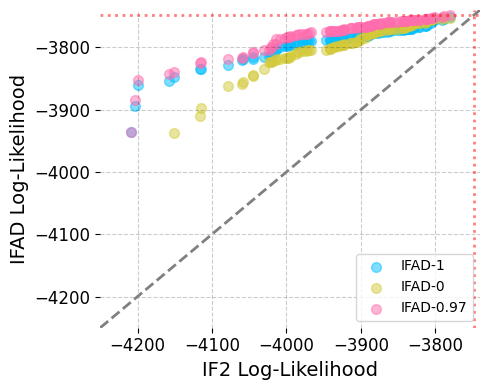

In [63]:
# IF2 0.95
plt.figure(figsize=(5,4))
# Overall paired searches, our IF2
plt.scatter(mifs.sort_values(), runs[1.0].sort_values(), marker='o', alpha=0.5,
            label='IFAD-1')
plt.scatter(mifs.sort_values(), runs[0.0].sort_values(), marker='o', alpha=0.5,
            label='IFAD-0')
plt.scatter(mifs.sort_values(), runs[0.97].sort_values(), marker='o', alpha=0.5,
            label='IFAD-0.97')
lo, hi = -4250, -3740
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5)

#plt.title('IFAD v.s. IF2, Paired Searches')

plt.xlabel('IF2 Log-Likelihood')
plt.ylabel('IFAD Log-Likelihood')
plt.legend()
plt.tight_layout()
# put horizontal and vertical lines at 3748.5
#plt.text(-3835, -3755, 'A', fontsize=36)

/home/kevin/anaconda3/envs/313/lib/python3.13/site-packages/ptitprince/PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/home/kevin/anaconda3/envs/313/lib/python3.13/site-packages/ptitprince/PtitPrince.py:1070: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.boxplot(
/home/kevin/anaconda3/envs/313/lib/python3.13/site-packages/ptitprince/PtitPrince.py:779: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.stripplot(


Text(-3895, 0, 'B')

<Figure size 500x400 with 0 Axes>

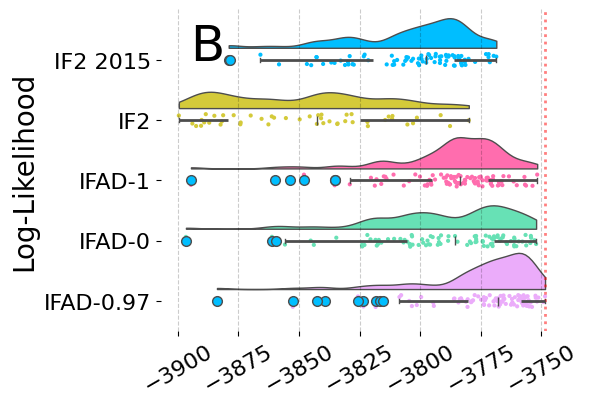

: 

In [ ]:
#IF2 0.95
import pyreadr
from scipy.special import logsumexp
import seaborn as sns
plt.style.use('matplotlibrc')
plt.figure(figsize=(5,4))
result = pyreadr.read_r('cholera-mif1-mif2.rda')

length = len(mifs)
data = pd.DataFrame({'IF2 2015': np.pad(logsumexp(result['m2.lik'], axis=0)[:length], 
                                        (0,max(0,length-100)), constant_values=np.nan),
              'IF2': mifs,    
              'IFAD-1': runs[1.0],
              'IFAD-0' : runs[0.0],
              'IFAD-0.97' : runs[0.97]})


dx="group"; dy="score"; ort="h"; pal = "Set2"; sigma = 0.2
pal = sns.color_palette([tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4)) for h in ['00BEFF', 'D4CA3A', 'FF6DAE', '67E1B5', 'EBACFA', 
                                             '9E9E9E', 'F1988E', '5DB15A', 'E28544', '52B8AA']], 10)
fig, ax = plt.subplots(figsize=(7/1.2, 5/1.2))

ax=pt.RainCloud(x = 'variable', y = 'value', 
                data = data[data>-3900].melt(), bw = sigma,
                palette=pal,
                 width_viol = 1.2, ax = ax, orient = ort
                 )
plt.xlabel('')
plt.ylabel('Log-Likelihood')


plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.ylabel('Log-Likelihood', fontsize=20)
plt.xticks(rotation=30, fontsize=16)
plt.yticks(rotation=0, fontsize=16)
#plt.title('Boxplot Comparison of Performance, Best of 10 Runs')
plt.tight_layout()
plt.text(-3895, 0, 'B', fontsize=36)